# Advanced plotting

In this notebook, we explore some of the more advanced plotting features including:
 - plotting functions
 - controlling the plotting output (placement of labels, axes range, colors, figure size)
 - accessing the underlying matplotlib and bokeh interfaces to fine tune your plots

## Plotting functions

In addition to plotting data sets, QExPy allows you to add functions on your plots. Because QExPy knows how to handle numbers with uncertainties, the parameters of the functions can be Measurement Objects, and the resulting function can be plotted with error bands.

We start by importing the module and choosing the plot engine. 

In [11]:
import qexpy as q
q.plot_engine="bokeh" # choose bokeh or mpl

To simply plot a function, we can define a Plot Object, and add a function to it. The function must be specified in the same format as a custom function that is being fit (see notebook 5).

We can also choose the number of points to use when plotting the function. By default, this is 100. If a function oscillates rapidly, then this may need to be increased. Of course, increasing this slows down the plotting. 

In [12]:
#We need to import numpy to define a function properly:
import numpy as np

#make an empty plot
fig1 = q.MakePlot()

#This will plot the function very coarsely
q.settings["plot_fcn_npoints"]=10

#define a python function to plot:
#let's plot a linear + gaussian:
def lineargauss(x, *pars):
    offset = pars[0]
    slope = pars[1]
    norm = pars[2]
    mean = pars[3]
    sigma = pars[4]
    
    linear = offset + slope*x
    gaussian = norm/np.sqrt(2*3.14)/sigma*np.exp(-(x-mean)**2/2/sigma**2)
    
    return linear + gaussian



#We can then add the function, naming it, giving the parameters, and specifying
#the range over which to plot it
fig1.add_function(lineargauss, name="linear + gauss", pars = [2,0.5,10,5,1],
                  color = 'saddlebrown',
                  x_range =[0,20])

#And we can then show it:
fig1.show()


### Plotting a function of parameters with uncertainties (and adding labels and changing the figure size)
We can replot the same function, but with parameters that have uncertainties. Suppose that we want to see the effect of an uncertainty in the normalization of the gaussian (the third parameters, pars[2]):

In [13]:
#Make a new figure:
fig2 = q.MakePlot()

#Set the range:
fig2.x_range=[0,10]

#Plot with more points:
q.settings["plot_fcn_npoints"]=100


#Store the paramaters for the function as a MeasurementArray
#Note that we chose only the third parameter to have a non-zero
#uncertainty
pars = q.MeasurementArray( [(2,0),
                            (0.5,0),
                            (10,2),
                            (5,0),
                            (1,0)])

#Add the function
fig2.add_function(lineargauss, pars = pars, name="uncertainty in norm",
                  color='darkkhaki',
                  x_range =[0,20])

#Let's also change the title of the axes:
fig2.labels["xtitle"]="energy [MeV]"
fig2.labels["ytitle"]="number of counts"
fig2.labels["title"]="location of the particle resonnance"

#Let's change the figure size, by giving dimensions in pixels:
fig2.dimensions_px = [800,400]

#show the figure
fig2.show()

## Use function plotting to show 2 different fits to the same dataset

By default, QExPy only shows the last fit to a dataset when plotting that dataset. However, we saw earlier that a dataset recalls all functions that were fit to it (and the results). Below, we generate a dataset programatically, then fit it to two functions and compare the results.


In [14]:
##############################
#Programatically generate data
##############################

#Generate some values around the x axis
xvals = np.linspace(0,20, 50)
#Generate values of y for those x values, normally distributed
#about our model:
#"true" parameters of the model:
true_pars = [1,0.1,20,8,1]
#the y values with some randomness:
yvals = np.random.normal(lineargauss(xvals, *true_pars),0.5)

##################
#Build the dataset
##################
xydata = q.XYDataSet(xdata = xvals, ydata = yvals, yerr = 0.5)
#Set the name of the dataset:
xydata.name = "Run10_Data"
xydata.xname = "Energy"
xydata.xunits = "MeV"
xydata.yname = "Counts"

#######################################
#Fit the data set to 2 different models
#######################################

#Let's fit it to a gaussian and to a linear+gaussian
#to see which one is best:

###Fit to a gaussian
#For the gaussian, we use the built in model:
#For a gaussian, it's best to give a guess for the parameters
gresults = xydata.fit("gaussian", parguess = [8,1,20])

###Fit to our custom model:
lgresults = xydata.fit(lineargauss, parguess = [1,1,1,8,1])

####################
#Display the results
####################

#Build a plot object:
fig3 = q.MakePlot(xydata)
#This will automatically display the last fit, so we add a function 
#for the first fit:
fig3.add_function(xydata.fit_function[0],
                  name = 'gaussian',
                  pars = xydata.fit_pars[0],
                  color = 'blue')
#The plot is a little busy if we show the fit results, so we don't show them:
fig3.show_fit_results = False
#The residuals will only be shown for the last fit
fig3.add_residuals()
fig3.show()


-----------------Fit results-------------------
Fit of  Run10_Data  to  gaussian
Fit parameters:
Run10_Data_gaussian_fit0_fitpars_mean = 8.1 +/- 0.2,
Run10_Data_gaussian_fit0_fitpars_sigma = 1.4 +/- 0.2,
Run10_Data_gaussian_fit0_fitpars_normalization = 32 +/- 3

Correlation matrix: 
[[  1.000e+00  -4.736e-08  -4.885e-09]
 [ -4.736e-08   1.000e+00   5.774e-01]
 [ -4.885e-09   5.774e-01   1.000e+00]]

chi2/ndof = 664.12/46
---------------End fit results----------------

-----------------Fit results-------------------
Fit of  Run10_Data  to  custom
Fit parameters:
Run10_Data_custom_fit1_fitpars_par0 = 0.9 +/- 0.2,
Run10_Data_custom_fit1_fitpars_par1 = 0.10 +/- 0.01,
Run10_Data_custom_fit1_fitpars_par2 = 20.6 +/- 0.9,
Run10_Data_custom_fit1_fitpars_par3 = 8.03 +/- 0.04,
Run10_Data_custom_fit1_fitpars_par4 = 1.03 +/- 0.05

Correlation matrix: 
[[ 1.    -0.848 -0.441  0.09  -0.284]
 [-0.848  1.     0.203 -0.106  0.131]
 [-0.441  0.203  1.    -0.022  0.645]
 [ 0.09  -0.106 -0.022  1.    -0.01

## Using the underlying bokeh interface
In the figure above, we would like to see the residuals from the first fit (the blue curve), since by default, QExPy will only show the results of the last fit. We can do this by modifying how we draw the figure. When we call show() on a Plot Object, QExPy will first create a figure, then populate it, then show it. We can modify the figure at any point during the show command, if we tell show() not to populate the figure (as this will erase the figure and start from scratch by default)

In [15]:
#First we populate the figure (with Bokeh, this starts from an empty figure)
fig3.populate_bokeh_figure()
#Then, we add the residuals from the first fit (fit index = 0)
fig3.bk_plot_dataset(xydata,residual=True, fit_index=0, color='blue')
#And now we show the figure, but ask QExPy not to populate it, since we
#already did
fig3.show(populate_figure=False)

# Using the backends
QExPy was designed to enable the user to access and manipulate the plotting backends if needed. This can be done when there is a feature in Bokeh or Matplotlib that isn't implemented in QExPy.

## Bokeh
Bokeh provides a number of useful plotting and graphing features that aren't used by QExPy. When initialize_bokeh_figure() is called, it returns a Bokeh figure object that can be manipulated before plotting. Again, we won't want to populate the figure before we show it, since that would clear all the changes we made to the Bokeh figure. We will do a simple example that involves drawing three annuli. A full reference for Bokeh plotting and figure objects can be found here: http://bokeh.pydata.org/en/latest/docs/reference/plotting.html

In [16]:
q.plot_engine='bk'
#First we make the QExPy plot and set the x and y ranges.
fig4 = q.MakePlot()
fig4.x_range=[0,10]
fig4.y_range=[0,10]
#Then we populate the Bokeh figure (with Bokeh, this starts from an empty figure)
bkfigure = fig4.initialize_bokeh_figure()
#Then we draw the annuli, using figure.annulus from Bokeh.
bkfigure.annulus(x=[1, 5, 9], y=[1, 5, 9], color="#7FC97F",
             inner_radius=0.2, outer_radius=0.5)
#And now we show the figure, but ask QExPy not to populate it, since we already did
fig4.show(populate_figure=False)

## Matplotlib
The Matplotlib backend can also be accessed for more customizable plotting. We use the same method to access the backend as with Bokeh. For the most part, you will want to access the figure's Axis object, and then display onto that. The documentation for this object can be found here: https://matplotlib.org/api/figure_api.html

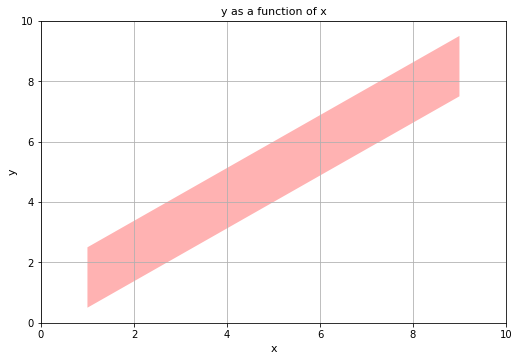

In [51]:
q.plot_engine='mpl'
#First we make the QExPy plot and set the x and y ranges.
fig5 = q.MakePlot()
fig5.x_range=[0,10]
fig5.y_range=[0,10]
#Then we populate the Matplotlib figure
mplfigure = fig5.initialize_mpl_figure()
#Most things in matplotlib are drawn onto a Axis object, so we should get that.
axis = mplfigure.gca()
#We will now draw an arbitrary object using Axis.fill_between()
axis.fill_between([1, 9], [0.5, 7.5],  [2.5, 9.5], facecolor='r',
                  alpha=0.3, edgecolor = 'none',
                  interpolate=True, zorder=0)
#And now we show the figure, but ask QExPy not to populate it, since we already did
fig5.show(populate_figure=False)